In [39]:
import pandas as pd
import numpy as np
import string
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, NMF, PCA
from sklearn.cluster import KMeans
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_sci_lg
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

%matplotlib inline

In [2]:
df = pd.read_csv('../dataset/arxiv_sampled.csv')

In [90]:
df.head()

,id,authors,title,categories,abstract,update_date,latest_version_year,processed_abstract
0,2110.14541,"Yoel Bokobza, Ron Dabora and Kobi Cohen",Deep Reinforcement Learning for Simultaneous S...,"['cs.IT', 'cs.LG', 'math.IT']",We consider the problem of dynamic spectrum ...,2021-10-28,2021,consider problem dynamic spectrum access ds...
1,2209.05330,"Erik Fitzke, Florian Niederschuh, and Thomas W...",Generating Functions and Automatic Differentia...,['quant-ph'],A simple and versatile method to simulate th...,2022-09-13,2022,simple versatile method simulate photon sta...
2,2105.12470,"Carlos Vega, Miguel Bello, Diego Porras and Al...",Qubit-photon bound states in topological waveg...,['quant-ph'],Quantum emitters interacting with photonic b...,2021-11-29,2021,quantum emitter interact photonic band-gap ...
3,2205.06071,Rylee Alanza Lyman,On Whitehead's cut vertex lemma,"['math.GR', 'math.GT']",One version of Whitehead's famous cut vertex...,2022-09-13,2022,version whitehead famous cut vertex lemma e...
4,2205.10915,"Chenyang Xu, Ziquan Zhuang",Stable degenerations of singularities,"['math.AG', 'math.AC', 'math.DG']",For any Kawamata log terminal (klt) singular...,2022-05-24,2022,kawamata log terminal klt singularity minim...


In [3]:
parser = en_core_sci_lg.load()
stop_words = list(STOP_WORDS)
stop_words += ['able', 'ability', 'accord', 'cause']
punctuations = string.punctuation

def tokenizer(s):
    tokens = parser(s)
    all_tokens = []
    for t in tokens:
        token = t.lemma_.lower()
        if token not in stop_words and token not in punctuations\
            and token != '\n':
            all_tokens.append(token)
    return ' '.join(all_tokens)

In [21]:
indexes = vec.keys()
for index in indexes:
    print(index)

100
20
2d
3d
ability
able
access
accord
account
accurate
accurately
act
action
active
activity
adapt
adaptive
add
additional
additionally
adopt
advance
advantage
adversarial
affect
agent
agreement
al
algebra
algebraic
alpha
alternative
amplitude
analytic
analytical
and
angle
answer
appear
appropriate
approximate
approximation
arbitrary
architecture
area
argue
arise
article
artificial
aspect
assess
assume
assumption
asymptotic
attack
attention
attribute
automatic
automatically
average
avoid
background
band
baseline
basic
basis
bayesian
behaviour
benchmark
benefit
bias
binary
bind
black
block
body
boundary
break
broad
build
calculate
calculation
candidate
capability
capable
capture
carlo
carry
category
cause
cell
center
central
certain
chain
challenging
channel
characteristic
characterization
characterize
charge
choice
choose
classify
close
cloud
cluster
co
coefficient
collect
collision
com
combination
come
common
commonly
communication
community
compact
comparable
comparison
competitive

In [4]:
tqdm.pandas()
df['processed_abstract'] = df.abstract.progress_apply(tokenizer)

100%|█████████████████████████████████████| 50000/50000 [26:35<00:00, 31.34it/s]


In [5]:
corpus = df.processed_abstract.values

vectorizer = TfidfVectorizer(min_df=0.016,
                             max_df=0.05)
doc_term_matrix = vectorizer.fit_transform(corpus)
vec = pd.DataFrame(doc_term_matrix.toarray(),
                   columns=vectorizer.get_feature_names_out())
feature_names = vectorizer.get_feature_names_out()

In [6]:
vec.head()

,100,20,2d,3d,ability,able,access,accord,account,accurate,...,volume,wave,weak,weight,well,wide,widely,year,yield,zero
0,0.0,0.0,0.0,0.0,0.0,0.0,0.602209,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.098619,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.311555,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
topic_num = 20
lsa = TruncatedSVD(n_components=topic_num)
lsa.fit(doc_term_matrix)

TruncatedSVD(n_components=20)

In [8]:
W = lsa.transform(doc_term_matrix)
H = lsa.components_

In [9]:
topics = []
for i in range(topic_num):
    topics.append([])

HT = np.transpose(H)
    
for i in range(len(HT)):
    l = HT[i].tolist()
    max_index = l.index(max(l))
    topics[max_index].append(feature_names[i])

In [10]:
for i, t in enumerate(topics):
    print(topics[i][:10])

['100', '20', 'ability', 'able', 'accord', 'account', 'accurate', 'accurately', 'act', 'active']
['angle', 'band', 'break', 'calculation', 'charge', 'coupling', 'dependence', 'electron', 'electronic', 'fluctuation']
['algebraic', 'analytic', 'asymptotic', 'certain', 'coefficient', 'compact', 'complete', 'conjecture', 'construction', 'converge']
['alpha', 'binary', 'candidate', 'cluster', 'constrain', 'core', 'early', 'evolution', 'fit', 'formation']
['automatic', 'category', 'com', 'content', 'embedding', 'fine', 'github', 'https', 'pre', 'recognition']
['access', 'communication', 'demand', 'distribute', 'experience', 'guarantee', 'minimize', 'online', 'platform', 'technology']
['mathcal']
['2d', '3d', 'background', 'detector', 'imaging', 'light', 'mu', 'optical', 'photon', 'reconstruction']
['answer', 'language', 'medium', 'natural', 'production', 'program', 'question', 'social']
['action', 'agent', 'black', 'decision', 'environment', 'frame', 'gravitational', 'gravity', 'hole', 'huma

In [11]:
Xs = []
for i in range(topic_num):
    Xs.append(W[:, i].tolist())

In [12]:
XsT = np.transpose(Xs)

In [13]:
# tune k
inertia = []

for num_clusters in range(1, 21):
    km = KMeans(n_clusters=num_clusters,
                random_state=42,
                n_init=20)
    km.fit(XsT)
    inertia.append(km.inertia_)

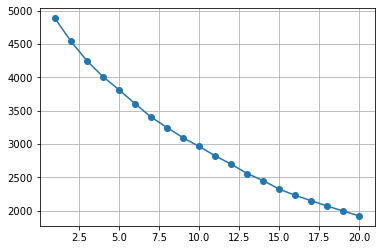

In [14]:
plt.plot(range(1, 21), inertia, marker='o')
plt.grid(True)
plt.show()

In [43]:
km = KMeans(n_clusters=14,
            random_state=42,
            n_init=20)
km.fit(XsT)
clusters = km.labels_

In [75]:
pca = PCA(n_components=2, random_state=42)
pca.fit(W)
W_t = pca.transform(W)

In [83]:
X = []
for i in range(14):
    X.append([])
    
for i in range(50000):
    X[clusters[i]].append(i)

<AxesSubplot:>

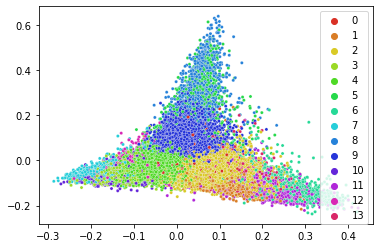

In [82]:
palette = sns.hls_palette(14, l=.5, s=.7)

sns.scatterplot(x=W_t[:, 0],
                y=W_t[:, 1],
                hue=clusters,
                palette=palette,
                s=10)

In [101]:
topic_paper = X[1][:10]
for i in topic_paper:
    print(df.loc[i, 'title'])
    print(df.loc[i, 'categories'])

Linking nearby stellar streams to more distant halo overdensities
['astro-ph.GA']
Super stellar abundances of alkali metals suggest significant migration
  for Hot Jupiters
['astro-ph.EP', 'astro-ph.SR']
NLTE CNO abundances in a sample of nine field RR lyr type stars
['astro-ph.SR']
AGN on the move: A search for off-nuclear AGN from recoiling SMBHs and
  ongoing galaxy mergers with the Zwicky Transient Facility
['astro-ph.GA', 'astro-ph.HE']
Symplectic 4-Manifolds on the Noether Line and between the Noether and
  Half Noether Lines
['math.GT', 'math.AG', 'math.SG']
TOI-712: a system of adolescent mini-Neptunes extending to the habitable
  zone
['astro-ph.EP']
Fluorine Abundances in the Galactic Nuclear Star Cluster
['astro-ph.GA', 'astro-ph.SR']
The Value-Added Catalog of ASAS-SN Eclipsing Binaries: Parameters of
  Thirty Thousand Detached Systems
['astro-ph.SR']
A new constant behind the rotational velocity of galaxies
['gr-qc']
3D hydrodynamical survey of the impact of a companion on

In [102]:
topic_paper = X[3][:10]
for i in topic_paper:
    print(df.loc[i, 'title'])
    print(df.loc[i, 'categories'])

Fast and Reliable Probabilistic Face Embeddings in the Wild
['cs.CV']
Scalable Vision Transformers with Hierarchical Pooling
['cs.CV']
ChiNet: Deep Recurrent Convolutional Learning for Multimodal Spacecraft
  Pose Estimation
['cs.CV', 'cs.AI', 'cs.LG', 'eess.IV']
Event and Activity Recognition in Video Surveillance for Cyber-Physical
  Systems
['cs.CV', 'cs.LG', 'cs.RO']
Improving Online Performance Prediction for Semantic Segmentation
['cs.CV']
EcoFormer: Energy-Saving Attention with Linear Complexity
['cs.CV', 'cs.CL', 'cs.LG', 'cs.NE']
Few-Shot Action Localization without Knowing Boundaries
['cs.CV']
Transfer Learning from an Artificial Radiograph-landmark Dataset for
  Registration of the Anatomic Skull Model to Dual Fluoroscopic X-ray Images
['eess.IV', 'cs.CV']
An Effective Graph Learning based Approach for Temporal Link Prediction:
  The First Place of WSDM Cup 2022
['cs.SI', 'cs.AI', 'cs.IR', 'cs.LG']
Image Segmentation Using Text and Image Prompts
['cs.CV']
